## Simulation of the toda lattice and its lyapunov exponents

Fixed params:
- N = 32 nodes
- Initial half sin wave, 0 velocity
- timespan up to 100 with dt = 1
- random seed = 0
- lr = 0.001
- epochs = 1000

In [47]:
"""Imports"""
import random
from scipy.integrate import solve_ivp
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm

In [48]:
"""Seed"""
random.seed(0)
torch.random.manual_seed(0)

"""Parameters"""
# General params
N = 32
q0 = np.array([np.sin(i*np.pi/(N-1)) for i in range(N)],dtype=np.float64)
p0 = np.array([0 for i in range(N)],dtype=np.float64)
# Avoiding overflow error
TMAX = 100
dt = 1
t_eval = np.linspace(0, TMAX, int(TMAX//dt)+1)

"""list of 100 perturbation vectors"""
epsilon_vecs = []
for i in tqdm(range(5)):
    random_vec = np.random.uniform(-0.5,0.5,size=2*N)
    random_vec /= np.linalg.norm(random_vec)
    epsilon_vecs.append(random_vec)

100%|██████████| 5/5 [00:00<?, ?it/s]


In [49]:
"""RK45"""
def toda_rhs(t, y):
    q = y[:N]
    p = y[N:]

    dqdt = p.copy()

    dVdq = np.zeros(N)
    for i in range(N):
        dVdq[i] = np.exp(-(q[(i + 1) % N] - q[i])) - np.exp(-(q[i] - q[(i - 1) % N]))
    dpdt = -dVdq

    return np.concatenate([dqdt, dpdt])

# Integrate the system
y0 = np.concatenate([q0,p0])
sol = solve_ivp(toda_rhs, [0, TMAX], np.concatenate([q0,p0]), t_eval=t_eval, method='RK45', rtol=1e-8, atol=1e-8)
soly = sol.y

# Solve for the lyapunov exponent
perturbed_y_list = []
for eps_vec in tqdm(epsilon_vecs):
    perturbed_sol = solve_ivp(toda_rhs, [0,TMAX], y0 + eps_vec, t_eval=t_eval, method='RK45', rtol=1e-8, atol=1e-8)
    perturbed_y_list.append(perturbed_sol.y)

100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


In [50]:
lyapunov_times = [i/(len(t_eval)/TMAX) for i in range(0,len(t_eval)+1,int(len(t_eval)//20))]
lyap_vals = []
for i in range(0,len(t_eval)+1,int(len(t_eval)//20)):
    if i == len(t_eval):
        i = len(t_eval)-1
    lyaps = []
    for perturbed_y in perturbed_y_list:
        yT = soly[:,i]
        yprimeT = perturbed_y[:,i]
        uT = yT-yprimeT
        lyap = np.log(np.linalg.norm(uT)/np.linalg.norm(eps_vec))/TMAX
        lyaps.append(lyap)
    lyap_vals.append(np.mean(lyaps))

In [ ]:
"""PINN"""
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q0_torch = torch.tensor(q0, dtype=torch.float32).to(device)
p0_torch = torch.tensor(p0, dtype=torch.float32).to(device)

diff = q0_torch[1:] - q0_torch[:-1]
initial_potential = torch.sum(torch.exp(diff) - (diff) - 1)
initial_potential += torch.exp(q0_torch[0] - q0_torch[-1]) - (q0_torch[0] - q0_torch[-1]) -1
initial_kinetic_energy = torch.sum(p0_torch**2/2)
initial_ham = initial_kinetic_energy + initial_potential


j_vals = np.arange(N)
t_vals = np.linspace(0, TMAX, int(TMAX//dt)+1)

jj, tt = np.meshgrid(j_vals, t_vals, indexing='ij')
jt_inputs = np.stack([jj.flatten(), tt.flatten()], axis=1)
jt_tensor = torch.tensor(jt_inputs, dtype=torch.float32, requires_grad=True).to(device)

j_indices = jt_tensor[:, 0].detach().cpu().numpy().astype(int)
t_indices = jt_tensor[:, 1].detach().cpu().numpy().astype(int)
reference_tensor = torch.tensor(soly[j_indices,t_indices],dtype=torch.float32, requires_grad=True).to(device)

class PINN(nn.Module):
    def __init__(self, hidden_dim, hidden_layers):
        super().__init__()
        self.net = nn.Sequential()
        layers = [nn.Linear(2,hidden_dim)]
        for i in range(hidden_layers):
            layers.append(nn.Linear(hidden_dim,hidden_dim))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden_dim,2))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)
    
model = PINN(40,4).to(device,dtype=torch.float32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=400, gamma=0.7)

def pinn_loss(jt):
    pred = model(jt)
    q_pred = pred[:, 0]
    p_pred = pred[:, 1]

    # PINN gradients
    dqdt = torch.autograd.grad(
        q_pred, jt, 
        grad_outputs=torch.ones_like(q_pred),
        create_graph=True
    )[0][:, 1]

    dpdt = torch.autograd.grad(
        p_pred, jt, 
        grad_outputs=torch.ones_like(p_pred),
        create_graph=True
    )[0][:, 1]

    # Creating j+1, j-1
    j = jt[:, 0]
    j_plus = (j + 1) % N
    j_minus = (j - 1) % N

    # q at j+1 and j-1
    jt_plus = torch.stack([j_plus, jt[:, 1]], dim=1)
    jt_minus = torch.stack([j_minus, jt[:, 1]], dim=1)

    q_plus = model(jt_plus)[:, 0]
    q_minus = model(jt_minus)[:, 0]

    force = torch.exp(-(q_plus - q_pred)) - torch.exp(-(q_pred - q_minus))

    # Differences in gradients
    ode_res_q = dqdt - p_pred
    ode_res_p = dpdt + force
    ode_loss = torch.mean(ode_res_q**2) + torch.mean(ode_res_p**2)

    # Initial condition loss
    # Only time = 0 
    mask_ic = jt[:, 1] == 0.0
    pred_ic = pred[mask_ic]

    # Predicted q
    ic_q = pred_ic[:, 0]
    # Predicted p
    ic_p = pred_ic[:, 1]

    ic_loss = torch.mean((ic_q - q0_torch)**2) + torch.mean((ic_p - p0_torch)**2)

        
    # Hamiltonian loss (should be time invariant)
    potential = torch.exp(q_plus-q_pred)-(q_plus-q_pred)-1
    potential = potential.view(potential.shape[0] // 32, 32)
    kinetic = (p_pred**2)/2
    kinetic = kinetic.view(kinetic.shape[0]//32, 32)
    potential_sums = potential.sum(dim=1)
    kinetic_sums = kinetic.sum(dim=1)
    hamiltonians = potential_sums+kinetic_sums
    initial_hamiltonian = torch.full((hamiltonians.shape[0],),initial_ham)
    hamiltonian_loss = torch.mean((hamiltonians - initial_hamiltonian)**2)

    value_loss = torch.mean((q_pred-reference_tensor)**2)

    return ode_loss + ic_loss + hamiltonian_loss + value_loss

# Training loop
num_epochs = 2000
losses = []
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    loss = pinn_loss(jt_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step() 
    if epoch % 400 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.6f}")
    losses.append(loss.item())
model = model.to('cpu')

  0%|          | 10/2000 [00:00<00:41, 47.58it/s]

Epoch 0, Loss = 1.449528


 20%|██        | 409/2000 [00:07<00:29, 53.51it/s]

Epoch 400, Loss = 0.044114


 40%|████      | 805/2000 [00:15<00:22, 52.66it/s]

Epoch 800, Loss = 0.040608


 60%|██████    | 1207/2000 [00:23<00:15, 52.44it/s]

Epoch 1200, Loss = 0.037962


 80%|████████  | 1609/2000 [00:30<00:07, 52.04it/s]

Epoch 1600, Loss = 0.036144


100%|██████████| 2000/2000 [00:38<00:00, 52.47it/s]


In [ ]:
"""Perturbed PINN"""
torch.manual_seed(0)

j_vals = np.arange(N)
t_vals = np.linspace(0, TMAX, int(TMAX//dt)+1)

jj, tt = np.meshgrid(j_vals, t_vals, indexing='ij')
jt_inputs = np.stack([jj.flatten(), tt.flatten()], axis=1)
jt_tensor = torch.tensor(jt_inputs, dtype=torch.float32, requires_grad=True).to(device)

j_indices = jt_tensor[:, 0].detach().cpu().numpy().astype(int)
t_indices = jt_tensor[:, 1].detach().cpu().numpy().astype(int)

perturbed = []
for _,eps_vec in enumerate(epsilon_vecs):
    q0_torch_perturbed = torch.tensor(q0+eps_vec[:N], dtype=torch.float32).to(device)
    p0_torch_perturbed = torch.tensor(p0+eps_vec[N:], dtype=torch.float32).to(device)
    
    diff = q0_torch_perturbed[1:] - q0_torch_perturbed[:-1]
    initial_potential = torch.sum(torch.exp(diff) - (diff) - 1)
    initial_potential += torch.exp(q0_torch_perturbed[0] - q0_torch_perturbed[-1]) - (q0_torch_perturbed[0] - q0_torch_perturbed[-1]) -1
    initial_kinetic_energy = torch.sum(p0_torch_perturbed**2/2)
    initial_ham = initial_kinetic_energy + initial_potential
    
    pert_model = PINN(40,4).to(device)
    optimizer = torch.optim.Adam(pert_model.parameters(), lr=1e-2)
    scheduler = StepLR(optimizer, step_size=400, gamma=0.7)
    reference_tensor = torch.tensor(perturbed_y_list[_][j_indices,t_indices], dtype=torch.float32).to(device)

    def pinn_loss(jt):
        pred = pert_model(jt)
        q_pred = pred[:, 0]
        p_pred = pred[:, 1]

        # PINN gradients
        dqdt = torch.autograd.grad(
            q_pred, jt, 
            grad_outputs=torch.ones_like(q_pred),
            create_graph=True
        )[0][:, 1] 

        dpdt = torch.autograd.grad(
            p_pred, jt, 
            grad_outputs=torch.ones_like(p_pred),
            create_graph=True
        )[0][:, 1]

        # Creating j+1, j-1
        j = jt[:, 0]
        j_plus = (j + 1) % N
        j_minus = (j - 1) % N

        # q at j+1 and j-1
        jt_plus = torch.stack([j_plus, jt[:, 1]], dim=1)
        jt_minus = torch.stack([j_minus, jt[:, 1]], dim=1)

        q_plus = pert_model(jt_plus)[:, 0]
        q_minus = pert_model(jt_minus)[:, 0]

        force = torch.exp(-(q_plus - q_pred)) - torch.exp(-(q_pred - q_minus))

        # Differences in gradients
        ode_res_q = dqdt - p_pred
        ode_res_p = dpdt + force
        ode_loss = torch.mean(ode_res_q**2) + torch.mean(ode_res_p**2)

        # Initial condition loss
        # Only time = 0 
        mask_ic = jt[:, 1] == 0.0
        pred_ic = pred[mask_ic]

        # Predicted q
        ic_q = pred_ic[:, 0]
        # Predicted p
        ic_p = pred_ic[:, 1]

        ic_loss = torch.mean((ic_q - q0_torch_perturbed)**2) + torch.mean((ic_p - p0_torch_perturbed)**2)
        
        
        # Hamiltonian loss (should be time invariant)
        potential = torch.exp(q_plus-q_pred)-q_plus-q_pred-1
        potential = potential.view(potential.shape[0] // 32, 32)
        kinetic = (p_pred**2)/2
        kinetic = kinetic.view(kinetic.shape[0]//32, 32)
        potential_sums = potential.sum(dim=1)
        kinetic_sums = kinetic.sum(dim=1)
        hamiltonians = potential_sums+kinetic_sums
        initial_hamiltonian = torch.full((hamiltonians.shape[0],),initial_ham)
        hamiltonian_loss = torch.mean((hamiltonians - initial_hamiltonian)**2)
        
        value_loss = torch.mean((q_pred-reference_tensor)**2)

        return ode_loss + ic_loss + hamiltonian_loss + value_loss
    
    
    # Training loop
    num_epochs = 2000
    losses = []
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        loss = pinn_loss(jt_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step() 
        if epoch % 400 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.6f}")
        losses.append(loss.item())
    
    perturbed.append(pert_model.to('cpu'))

  0%|          | 5/2000 [00:00<00:43, 46.32it/s]

Epoch 0, Loss = 143.097733


 20%|██        | 410/2000 [00:08<00:31, 51.03it/s]

Epoch 400, Loss = 2.234127


 40%|████      | 803/2000 [00:16<00:30, 39.63it/s]

Epoch 800, Loss = 2.212549


 60%|██████    | 1204/2000 [00:29<00:24, 31.90it/s]

Epoch 1200, Loss = 2.200395


 80%|████████  | 1604/2000 [00:41<00:12, 32.04it/s]

Epoch 1600, Loss = 2.189523


  0%|          | 4/2000 [00:00<00:58, 34.41it/s]

Epoch 0, Loss = 117.620163


 20%|██        | 408/2000 [00:12<00:46, 33.92it/s]

Epoch 400, Loss = 0.627646


 40%|████      | 808/2000 [00:24<00:35, 33.45it/s]

Epoch 800, Loss = 0.566452


 60%|██████    | 1204/2000 [00:36<00:24, 32.97it/s]

Epoch 1200, Loss = 0.553390


 80%|████████  | 1604/2000 [00:49<00:12, 32.56it/s]

Epoch 1600, Loss = 0.544127


  0%|          | 4/2000 [00:00<00:57, 34.49it/s]

Epoch 0, Loss = 14.264277


 20%|██        | 404/2000 [00:12<00:48, 32.99it/s]

Epoch 400, Loss = 2.207335


 40%|████      | 805/2000 [00:24<00:36, 32.97it/s]

Epoch 800, Loss = 2.177807


 60%|██████    | 1205/2000 [00:37<00:25, 31.51it/s]

Epoch 1200, Loss = 2.162273


 80%|████████  | 1605/2000 [00:48<00:12, 32.61it/s]

Epoch 1600, Loss = 2.152417


  0%|          | 4/2000 [00:00<00:58, 34.01it/s]

Epoch 0, Loss = 3797.784912


 20%|██        | 404/2000 [00:12<00:48, 32.79it/s]

Epoch 400, Loss = 0.505927


 40%|████      | 804/2000 [00:24<00:36, 32.51it/s]

Epoch 800, Loss = 0.429532


 60%|██████    | 1204/2000 [00:36<00:24, 32.47it/s]

Epoch 1200, Loss = 0.415443


 80%|████████  | 1604/2000 [00:49<00:12, 32.66it/s]

Epoch 1600, Loss = 0.410111


  0%|          | 4/2000 [00:00<00:59, 33.74it/s]

Epoch 0, Loss = 18.968109


 20%|██        | 404/2000 [00:12<00:48, 33.12it/s]

Epoch 400, Loss = 7.470933


 40%|████      | 804/2000 [00:24<00:36, 32.99it/s]

Epoch 800, Loss = 7.326019


 60%|██████    | 1204/2000 [00:36<00:23, 33.36it/s]

Epoch 1200, Loss = 6.916951


 80%|████████  | 1608/2000 [00:48<00:11, 33.42it/s]

Epoch 1600, Loss = 6.496669


100%|██████████| 2000/2000 [01:00<00:00, 33.18it/s]


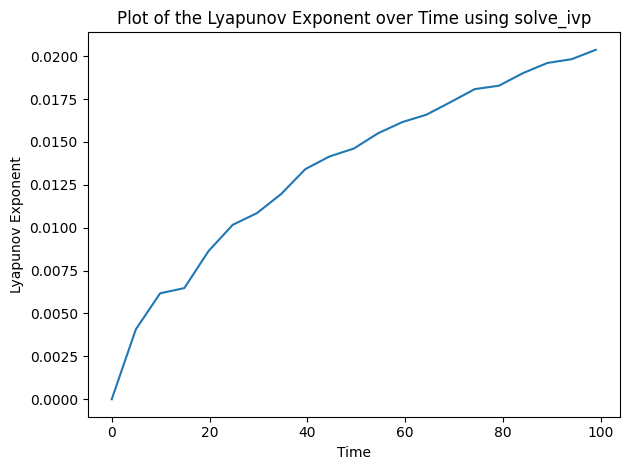

In [109]:
"""Plots of computed lyapunov exponent over time solve_ivp"""
plt.plot(lyapunov_times,lyap_vals)
plt.title('Plot of the Lyapunov Exponent over Time using solve_ivp')
plt.xlabel('Time')
plt.ylabel("Lyapunov Exponent")
plt.tight_layout()

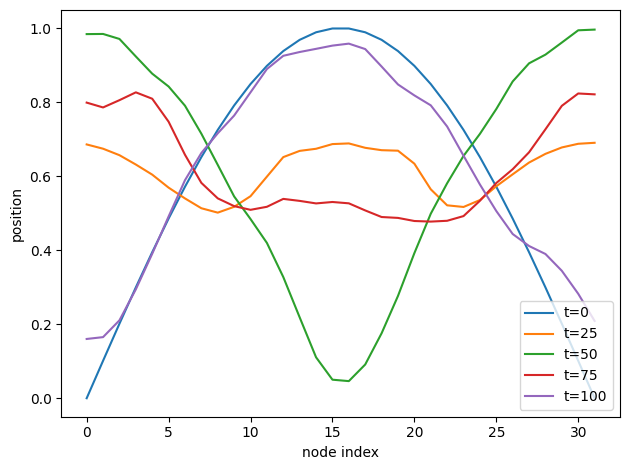

In [110]:
"""Plots of chain at time 0, 25, 50, 75, 100"""
plt.plot(soly[:N,0],label='t=0')
plt.plot(soly[:N,24],label='t=25')
plt.plot(soly[:N,49],label='t=50')
plt.plot(soly[:N,74],label='t=75')
plt.plot(soly[:N,99],label='t=100')
plt.xlabel('node index')
plt.ylabel('position')
plt.legend()
plt.tight_layout()

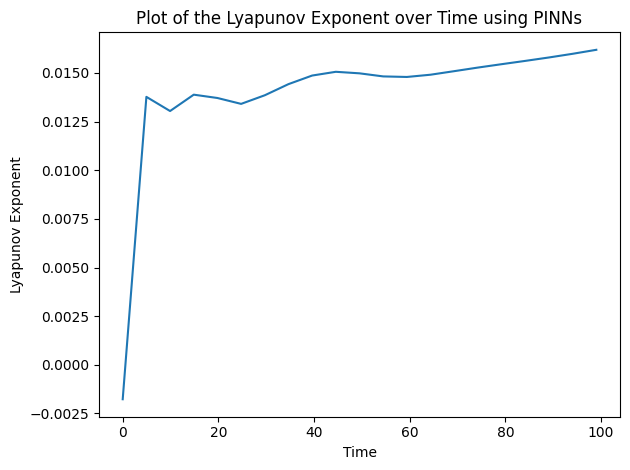

In [111]:
"""Plots of computed lyapunov exponent over time PINN"""
lyapunov_times = [i/(len(t_eval)/TMAX) for i in range(0,len(t_eval)+1,int(len(t_eval)//20))]
PINN_lyap_vals = []
for i in range(0,len(t_eval)+1,int(len(t_eval)//20)):
    lyaps = []
    if i == len(t_eval):
        i = len(t_eval)-1
    jT = (jt_tensor[jt_tensor[:,1]==t_eval[i]])
    final_vec = model(jT)
    for perturbed_model in perturbed:
        final_vec_perturbed = perturbed_model(jT)
        difference = torch.norm((final_vec_perturbed-final_vec).flatten())
        lyapunov = torch.log(difference)/TMAX
        lyaps.append(lyapunov.detach().cpu().numpy())
    PINN_lyap_vals.append(np.mean(lyaps))
plt.plot(lyapunov_times, PINN_lyap_vals)
plt.title('Plot of the Lyapunov Exponent over Time using PINNs')
plt.xlabel('Time')
plt.ylabel("Lyapunov Exponent")
plt.tight_layout()

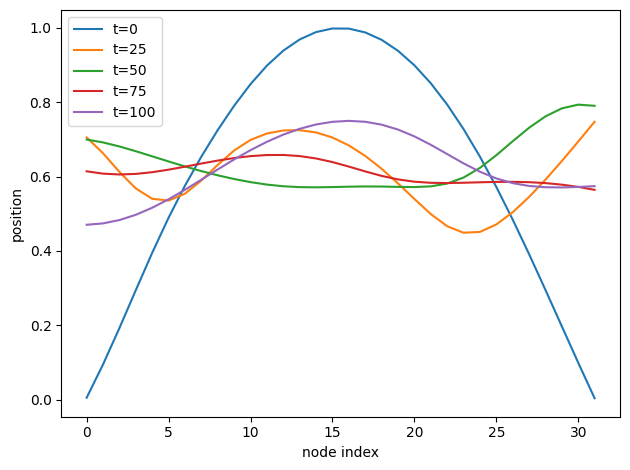

In [112]:
for i in [0,24,49,74,99]:
    j_indices = np.arange(N)
    t_inputs = np.full_like(j_indices, i)

    # Convert to tensors
    J_tensor = torch.tensor(j_indices, dtype=torch.float32)
    T_tensor = torch.tensor(t_inputs, dtype=torch.float32)

    inputs = torch.stack([J_tensor, T_tensor], dim=1)  # shape (N, 2)

    # Run the NN
    outputs = model(inputs)  # shape (N, 2)
    positions = outputs[:, 0].detach().numpy()

# plt.plot(q0)
    if i!=0:
        plt.plot(positions, label=f't={i+1}')
    else:
        plt.plot(positions, label="t=0")

plt.xlabel('node index')
plt.ylabel('position')
plt.legend()
plt.tight_layout()

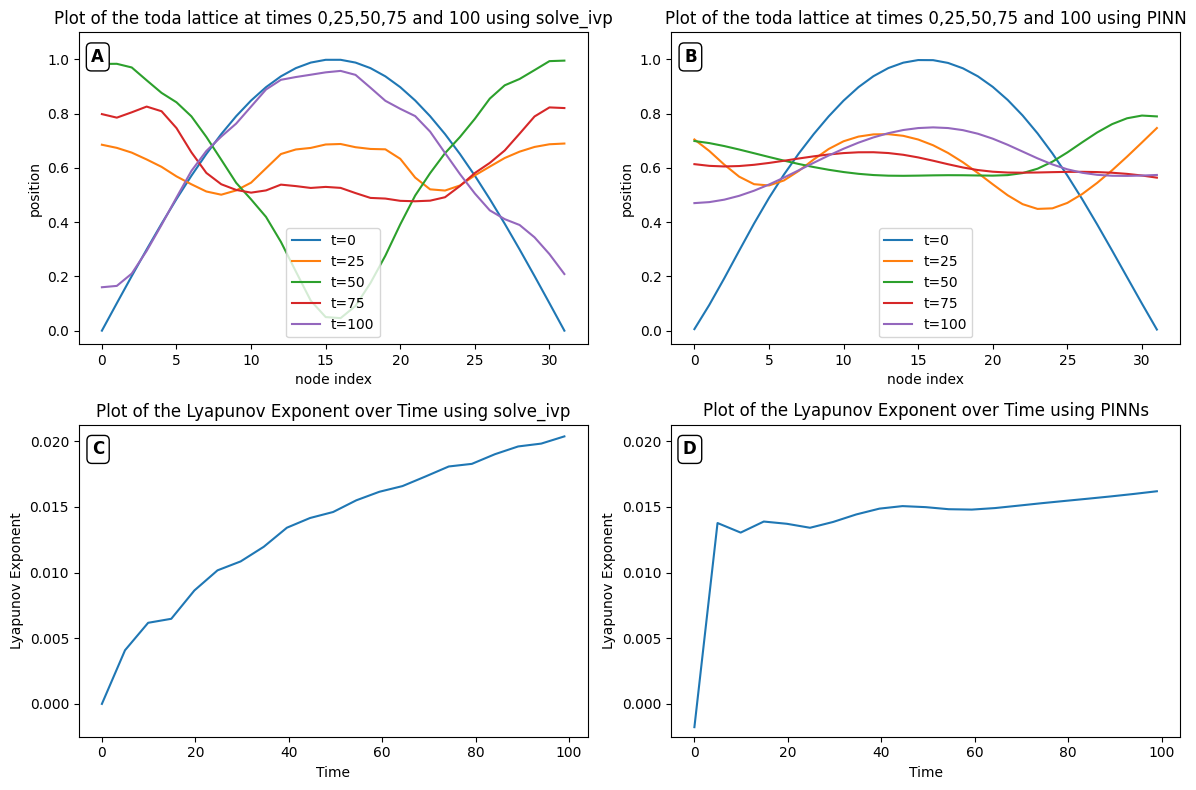

In [139]:
fig,ax = plt.subplots(figsize=(15*0.8,10*0.8),nrows=2,ncols=2)
ax[0,0].plot(soly[:N,0],label='t=0')
ax[0,0].plot(soly[:N,24],label='t=25')
ax[0,0].plot(soly[:N,49],label='t=50')
ax[0,0].plot(soly[:N,74],label='t=75')
ax[0,0].plot(soly[:N,99],label='t=100')
ax[0,0].set_xlabel('node index')
ax[0,0].set_ylabel('position')
ax[0,0].set_ylim(-0.05,1.1)
ax[0,0].legend()
ax[0,0].text(
        0.05, 0.95, "A",
        transform=ax[0,0].transAxes,
        fontsize=12,
        fontweight='bold',
        va='top', ha='right',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black')
)
ax[0,0].set_title('Plot of the toda lattice at times 0,25,50,75 and 100 using solve_ivp')


ax[1,0].plot(lyapunov_times,lyap_vals)
# plt.title('Plot of the Lyapunov Exponent over Time using solve_ivp')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel("Lyapunov Exponent")
# ax[1,0].tight_layout()
ax[1,0].text(
        0.05, 0.95, "C",
        transform=ax[1,0].transAxes,
        fontsize=12,
        fontweight='bold',
        va='top', ha='right',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black')
)

ax[1,0].set_title('Plot of the Lyapunov Exponent over Time using solve_ivp')
ax[1,0].set_ylim(-0.0025,0.02125)

for i in [0,24,49,74,99]:
    j_indices = np.arange(N)
    t_inputs = np.full_like(j_indices, i)

    # Convert to tensors
    J_tensor = torch.tensor(j_indices, dtype=torch.float32)
    T_tensor = torch.tensor(t_inputs, dtype=torch.float32)

    inputs = torch.stack([J_tensor, T_tensor], dim=1)  # shape (N, 2)

    # Run the NN
    outputs = model(inputs)  # shape (N, 2)
    positions = outputs[:, 0].detach().numpy()

# plt.plot(q0)
    if i!=0:
        ax[0,1].plot(positions, label=f't={i+1}')
    else:
        ax[0,1].plot(positions, label="t=0")
ax[0,1].set_xlabel('node index')
ax[0,1].set_ylabel('position')
ax[0,1].legend()
# plt.tight_layout()
ax[0,1].text(
        0.05, 0.95, "B",
        transform=ax[0,1].transAxes,
        fontsize=12,
        fontweight='bold',
        va='top', ha='right',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black')
)
ax[0,1].set_ylim(-0.05,1.1)
ax[0,1].set_title('Plot of the toda lattice at times 0,25,50,75 and 100 using PINN')



lyapunov_times = [i/(len(t_eval)/TMAX) for i in range(0,len(t_eval)+1,int(len(t_eval)//20))]
PINN_lyap_vals = []
for i in range(0,len(t_eval)+1,int(len(t_eval)//20)):
    lyaps = []
    if i == len(t_eval):
        i = len(t_eval)-1
    jT = (jt_tensor[jt_tensor[:,1]==t_eval[i]])
    final_vec = model(jT)
    for perturbed_model in perturbed:
        final_vec_perturbed = perturbed_model(jT)
        difference = torch.norm((final_vec_perturbed-final_vec).flatten())
        lyapunov = torch.log(difference)/TMAX
        lyaps.append(lyapunov.detach().cpu().numpy())
    PINN_lyap_vals.append(np.mean(lyaps))
ax[1,1].plot(lyapunov_times, PINN_lyap_vals)
# plt.title('Plot of the Lyapunov Exponent over Time using PINNs')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel("Lyapunov Exponent")
ax[1,1].text(
        0.05, 0.95, "D",
        transform=ax[1,1].transAxes,
        fontsize=12,
        fontweight='bold',
        va='top', ha='right',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black')
)
ax[1,1].set_title('Plot of the Lyapunov Exponent over Time using PINNs')
ax[1,1].set_ylim(-0.0025,0.02125)
plt.tight_layout()
